In [ ]:
import os
import random
import string
from flask import Flask, render_template, request, redirect, url_for, jsonify, send_from_directory
import cv2
from threading import Thread
import video_process2  

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'static/videos'
app.config['FRAME_FOLDER'] = 'static/frames'


# Dictionary to keep track of processing status
processing_status = {}

# Function to generate a random string
def random_string(length=10):
    """Generate a random string of letters and numbers."""
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Process the video frame by frame
def process_video(video_path, video_id):
    """Process the video and save up to 10 frames."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    # Setup VideoWriter to save the processed video
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    output_video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Process and save frames
    m=video_process2.Mo(fps)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame=m.process(frame)



        # Save the current frame with a specific identifier
        frame_filename = os.path.join(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
        cv2.imwrite(frame_filename, frame)

        # Write the current frame to the output video
        out.write(frame)

        frame_count += 1

        # Update processing status
        processing_status[video_id] = {
            'processed_frames': frame_count,
            'total_frames': total_frames,
            'completed': False,
            'show_download_link': False  # Initially set to False
        }

    # Mark processing as complete
    processing_status[video_id]['completed'] = True
    processing_status[video_id]['show_download_link'] = True  # Set to True when done
    cap.release()
    out.release()

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_video():
    if 'video' not in request.files:
        return 'No file part'
    
    file = request.files['video']
    if file.filename == '':
        return 'No selected file'
    
    if file:
        video_id = random_string()
        video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}.mp4")
        file.save(video_path)

        # Initialize processing status
        processing_status[video_id] = {
            'total_frames': 0,
            'processed_frames': 0,
            'completed': False,
            'show_download_link': False  # Initialize download link visibility
        }

        # Start a new thread to process the video
        thread = Thread(target=process_video, args=(video_path, video_id))
        thread.start()

        return redirect(url_for('processing_page', video_id=video_id))

@app.route('/processing/<video_id>')
def processing_page(video_id):
    """Page to show the progress of video processing."""
    return render_template('frames.html', video_id=video_id)

@app.route('/progress/<video_id>')
def progress(video_id):
    """Endpoint to check the progress of video processing."""
    if video_id in processing_status:
        status = processing_status[video_id]
        return jsonify(status)
    else:
        return 'Invalid video ID', 404

@app.route('/frame/<video_id>')
def get_frame(video_id):
    """Serve the current frame."""
    frame_path = os.path.join(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
    if os.path.exists(frame_path):
        return send_from_directory(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
    else:
        return 'Frame not found', 404

@app.route('/download/<video_id>')
def download_video(video_id):
    """Serve the processed video for download."""
    video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4")
    
    if os.path.exists(video_path):
        return send_from_directory(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4", as_attachment=True)
    else:
        return "File not found", 404

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Oct/2024 14:16:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:17] "POST /upload HTTP/1.1" 302 -
127.0.0.1 - - [05/Oct/2024 14:16:17] "GET /processing/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:17] "GET /processing/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:18] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:18] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:19] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:20] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:21] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:22] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:23] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 14:16:24] "GET /progress/rHdAcotBiq HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/

In [ ]:
import os
import random
import string
from flask import Flask, render_template, request, redirect, url_for, jsonify, send_from_directory, flash
import cv2
from threading import Thread
import video_process2

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'static/videos'
app.config['FRAME_FOLDER'] = 'static/frames'
app.secret_key = 'your_secret_key'

# Dictionary to keep track of processing status
processing_status = {}

# Function to generate a random string
def random_string(length=10):
    """Generate a random string of letters and numbers."""
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Process the video frame by frame
def process_video(video_path, video_id):
    """Process the video and save up to 10 frames."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    # Setup VideoWriter to save the processed video
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    output_video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Process and save frames
    m = video_process2.Mo(fps)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = m.process(frame)

        # Save the current frame with a specific identifier
        frame_filename = os.path.join(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
        cv2.imwrite(frame_filename, frame)

        # Write the current frame to the output video
        out.write(frame)

        frame_count += 1

        # Update processing status
        processing_status[video_id] = {
            'processed_frames': frame_count,
            'total_frames': total_frames,
            'completed': False,
            'show_download_link': False  # Initially set to False
        }

    # Mark processing as complete
    processing_status[video_id]['completed'] = True
    processing_status[video_id]['show_download_link'] = True  # Set to True when done
    cap.release()
    out.release()

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_video():
    if 'video' not in request.files:
        flash('No file part')
        return redirect(url_for('index'))
    
    file = request.files['video']
    if file.filename == '':
        flash('No selected file')
        return redirect(url_for('index'))
    
    # Check if the file is a video by MIME type
    if not file.mimetype.startswith('video/'):
        flash('File is not a valid video format. Please upload a video file.')
        return redirect(url_for('index'))

    # Additional file extension check
    allowed_extensions = {'mp4', 'avi', 'mov', 'mkv'}
    if not ('.' in file.filename and file.filename.rsplit('.', 1)[1].lower() in allowed_extensions):
        flash('Invalid file extension. Allowed extensions: mp4, avi, mov, mkv.')
        return redirect(url_for('index'))
    
    # Save the file
    video_id = random_string()
    video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}.mp4")
    file.save(video_path)

    # Initialize processing status
    processing_status[video_id] = {
        'total_frames': 0,
        'processed_frames': 0,
        'completed': False,
        'show_download_link': False  # Initialize download link visibility
    }

    # Start a new thread to process the video
    thread = Thread(target=process_video, args=(video_path, video_id))
    thread.start()

    return redirect(url_for('processing_page', video_id=video_id))

@app.route('/processing/<video_id>')
def processing_page(video_id):
    """Page to show the progress of video processing."""
    return render_template('frames.html', video_id=video_id)

@app.route('/progress/<video_id>')
def progress(video_id):
    """Endpoint to check the progress of video processing."""
    if video_id in processing_status:
        status = processing_status[video_id]
        return jsonify(status)
    else:
        return 'Invalid video ID', 404

@app.route('/frame/<video_id>')
def get_frame(video_id):
    """Serve the current frame."""
    frame_path = os.path.join(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
    if os.path.exists(frame_path):
        return send_from_directory(app.config['FRAME_FOLDER'], f"{video_id}_current_frame.jpg")
    else:
        return 'Frame not found', 404

@app.route('/download/<video_id>')
def download_video(video_id):
    """Serve the processed video for download."""
    video_path = os.path.join(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4")
    
    if os.path.exists(video_path):
        return send_from_directory(app.config['UPLOAD_FOLDER'], f"{video_id}_processed.mp4", as_attachment=True)
    else:
        return "File not found", 404

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Oct/2024 22:26:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:30] "POST /upload HTTP/1.1" 302 -
127.0.0.1 - - [05/Oct/2024 22:26:30] "GET /processing/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:30] "GET /processing/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:30] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:30] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
c:\Users\modya\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
127.0.0.1 - - [05/Oct/2024 22:26:31] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:32] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:33] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.

no object detected
no object detected


127.0.0.1 - - [05/Oct/2024 22:26:35] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:35] "GET /frame/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:37] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:37] "GET /frame/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:37] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:37] "GET /frame/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:38] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:38] "GET /frame/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:39] "GET /progress/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:39] "GET /frame/3HLisoKrU7 HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:47] "POST /upload HTTP/1.1" 302 -
127.0.0.1 - - [05/Oct/2024 22:26:47] "GET /processing/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05

no object detected


127.0.0.1 - - [05/Oct/2024 22:26:49] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:50] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:50] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:51] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:51] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:53] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:53] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:54] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:54] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:55] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:55] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:55] "POST /upload HTTP/1.1" 302 -
127.0.0.1 - - [05/O

no object detected


127.0.0.1 - - [05/Oct/2024 22:26:58] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:58] "GET /progress/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:58] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:58] "GET /frame/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:59] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:59] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:59] "GET /progress/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:26:59] "GET /frame/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:00] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:00] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:00] "GET /progress/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:00] "GET /frame/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:01] "GET /progress/gMbPui2Gue HTTP/1.

no object detected
no object detected


127.0.0.1 - - [05/Oct/2024 22:27:53] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -


no object detected
no object detected
no object detected
no object detected
no object detected
no object detected


127.0.0.1 - - [05/Oct/2024 22:27:54] "GET /progress/yPiYO2OpZT HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:54] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:54] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:54] "GET /frame/yPiYO2OpZT HTTP/1.1" 200 -


no object detected
no object detected
no object detected
no object detected
no object detected
no object detected


127.0.0.1 - - [05/Oct/2024 22:27:55] "GET /progress/gMbPui2Gue HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2024 22:27:55] "GET /frame/gMbPui2Gue HTTP/1.1" 200 -


In [2]:
fps=30
m=video_process2.Mo(fps)

In [3]:
video=cv2.VideoCapture(r"C:\Users\modya\Desktop\TEST\(GRAPHIC) Georgia_ Two Tractor Trailer Drivers Killed In Distracted Driving Crash In South Fulton.mp4")

In [4]:
s,frame=video.read()

c:\Users\modya\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


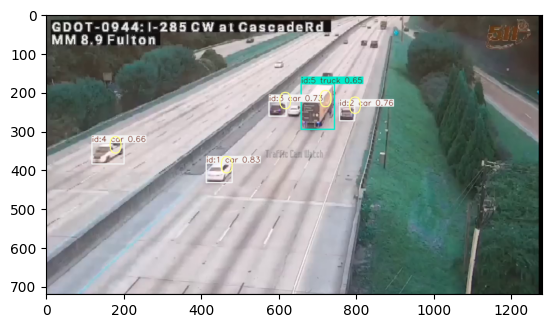

In [5]:
s,frame=video.read()
img=m.process(frame)
plt.imshow(img)

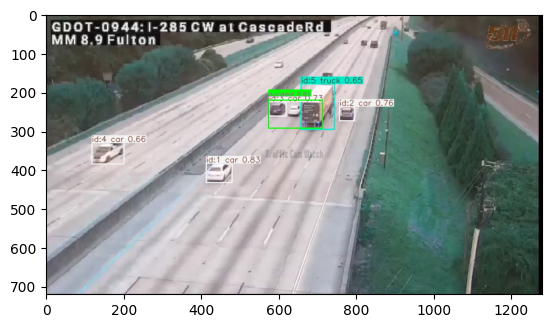

In [16]:
plt.imshow(img)